# Cross Validation

## Nested Cross Validation: 

- we create different split indexes based time-series with days as unit.
- we implement 3 splitts
- Random Hyper-parameters search 


### Imports

In [2]:
import csv
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras import layers, losses, callbacks, Sequential, optimizers, metrics
from tensorflow.keras.models import Model
from sklearn.pipeline import Pipeline

import pickle
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, roc_auc_score, precision_recall_curve

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib notebook

import wandb
from wandb.keras import WandbCallback

2021-10-02 20:42:38.779770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-02 20:42:38.779800: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import sys
module_path = sys.path.append('/home/ubuntu/nabu/anomaly_detection/src')
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data import *
from helpers import *
from models import *

In [4]:
RANDOM_SEED = 0

set_seed(RANDOM_SEED)

In [5]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

## W&B

In [65]:
%env WANDB_NOTEBOOK_NAME='/home/ubuntu/nabu/anomaly_detection/notebooks/Train-Evaluations-Loops.ipynb'

env: WANDB_NOTEBOOK_NAME='/home/ubuntu/nabu/anomaly_detection/notebooks/Train-Evaluations-Loops.ipynb'


In [66]:
wandb.login()

True

In [67]:
wandb.init(project="Train-Eval", entity="anomaly-idc")

Traceback (most recent call last):
  File "/usr/lib/python3.8/pkgutil.py", line 415, in get_importer
    importer = sys.path_importer_cache[path_item]
KeyError: None

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib/python3.8/multiprocessing/spawn.py", line 125, in _main
    prepare(preparation_data)
  File "/usr/lib/python3.8/multiprocessing/spawn.py", line 234, in prepare
    _fixup_main_from_name(data['init_main_from_name'])
  File "/usr/lib/python3.8/multiprocessing/spawn.py", line 258, in _fixup_main_from_name
    main_content = runpy.run_module(mod_name,
  File "/usr/lib/python3.8/runpy.py", line 203, in run_module
    mod_name, mod_spec, code = _get_module_details(mod_name)
  File "/usr/lib/python3.8/runpy.py", line 111, in _get_module_details
    __im

Problem at: /tmp/ipykernel_5384/2388631378.py 1 <module>


Traceback (most recent call last):
  File "/home/ubuntu/pyenv/lib/python3.8/site-packages/wandb/sdk/wandb_init.py", line 775, in init
    run = wi.init()
  File "/home/ubuntu/pyenv/lib/python3.8/site-packages/wandb/sdk/wandb_init.py", line 514, in init
    ret = backend.interface.communicate_run(run, timeout=30)
  File "/home/ubuntu/pyenv/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 661, in communicate_run
    return self._communicate_run(run, timeout=timeout)
  File "/home/ubuntu/pyenv/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 649, in _communicate_run
    resp = self._communicate(req, timeout=timeout)
  File "/home/ubuntu/pyenv/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 539, in _communicate
    return self._communicate_async(rec, local=local).get(timeout=timeout)
  File "/home/ubuntu/pyenv/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 544, in _communicate_async
    raise Exception("The wand

Exception: problem

# Load Data

In [6]:
DATA = Path('../data')
TRAIN_DATASET = DATA / 'train_data_new.csv'
TEST_DATASET = DATA / 'test_data_new.csv'

df_train = pd.read_csv(TRAIN_DATASET.resolve())
df_test = pd.read_csv(TEST_DATASET.resolve())

df_train.shape
df_test.shape

(1365979, 76)

(282925, 76)

In [7]:
df_train.columns

Index(['_id', 'session_id', 'sensor_id', 'port', 'ip', 'ts', 'country', 'tor',
       'packet_size', 'identify', 'agg_session_id_row_count',
       'agg_session_id_packet_size_sum', 'agg_session_id_packet_size_max',
       'agg_session_id_packet_size_min', 'agg_session_id_packet_size_mean',
       'agg_session_id_packet_size_std', 'agg_ip_row_count', 'ip_bit_0',
       'ip_bit_1', 'ip_bit_2', 'ip_bit_3', 'ip_bit_4', 'ip_bit_5', 'ip_bit_6',
       'ip_bit_7', 'ip_bit_8', 'ip_bit_9', 'ip_bit_10', 'ip_bit_11',
       'ip_bit_12', 'ip_bit_13', 'ip_bit_14', 'ip_bit_15', 'ip_bit_16',
       'ip_bit_17', 'ip_bit_18', 'ip_bit_19', 'ip_bit_20', 'ip_bit_21',
       'ip_bit_22', 'ip_bit_23', 'ip_bit_24', 'ip_bit_25', 'ip_bit_26',
       'ip_bit_27', 'ip_bit_28', 'ip_bit_29', 'ip_bit_30', 'ip_bit_31',
       'port_bit_0', 'port_bit_1', 'port_bit_2', 'port_bit_3', 'port_bit_4',
       'port_bit_5', 'port_bit_6', 'port_bit_7', 'port_bit_8', 'port_bit_9',
       'port_bit_10', 'port_bit_11', 'port_bi

In [8]:
df_test.columns

Index(['_id', 'session_id', 'sensor_id', 'port', 'ip', 'ts', 'country', 'tor',
       'packet_size', 'identify', 'agg_session_id_row_count',
       'agg_session_id_packet_size_sum', 'agg_session_id_packet_size_max',
       'agg_session_id_packet_size_min', 'agg_session_id_packet_size_mean',
       'agg_session_id_packet_size_std', 'agg_ip_row_count', 'ip_bit_0',
       'ip_bit_1', 'ip_bit_2', 'ip_bit_3', 'ip_bit_4', 'ip_bit_5', 'ip_bit_6',
       'ip_bit_7', 'ip_bit_8', 'ip_bit_9', 'ip_bit_10', 'ip_bit_11',
       'ip_bit_12', 'ip_bit_13', 'ip_bit_14', 'ip_bit_15', 'ip_bit_16',
       'ip_bit_17', 'ip_bit_18', 'ip_bit_19', 'ip_bit_20', 'ip_bit_21',
       'ip_bit_22', 'ip_bit_23', 'ip_bit_24', 'ip_bit_25', 'ip_bit_26',
       'ip_bit_27', 'ip_bit_28', 'ip_bit_29', 'ip_bit_30', 'ip_bit_31',
       'port_bit_0', 'port_bit_1', 'port_bit_2', 'port_bit_3', 'port_bit_4',
       'port_bit_5', 'port_bit_6', 'port_bit_7', 'port_bit_8', 'port_bit_9',
       'port_bit_10', 'port_bit_11', 'port_bi

# Best Features: IF

In [8]:
# TODO: save the feature selected .json file and add reading here what 

# read here json 
# best_general_features = read

In [9]:
BEST_FINAL_FEATURES = ['identify',
 'packet_size',
 'country',
 'ip',
 'sensor_id',
 'time_val',
 'tor',
 'agg_session_id_row_count',
 'agg_session_id_packet_size_sum',
 'agg_session_id_packet_size_max']


# NEW
FEATURES_WITHOUT_AGGS = ['identify',
 'packet_size',
 'country',
 'ip',
 'time_val',
 'tor']

# Models

In [9]:
def get_model(model_name: str, params: dict, input_dim: int = 0):
    if model_name == 'IF':
        model = IsolationForest(**params)
    elif model_name == 'IF_KMeans':
        model = IF_KMeans(**params)
    elif model_name == 'AutoEncoder':
        if not input_dim:
            print('Error: you must input input_dim size')
            return None
        model = AutoEncoders(input_dim, params['architecture'])
        model.compile(optimizer=params['optimizer'],
                      loss=params['loss'],
                      metrics=params['metrics'])
    return model


def get_callbacks(model):
    yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

    log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(model.layers)}'

    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=10,
        verbose=1, 
        mode='min',
        restore_best_weights=True
    )

    save_model = callbacks.ModelCheckpoint(
        filepath=f'{model.name}_best_weights.tf',
        save_best_only=True,
        monitor='val_loss',
        verbose=0,
        mode='min'
    )

    return [early_stop, save_model] #, WandbCallback(save_format="tf")]

# Utils

In [10]:
def eval_model(X, y, model, is_dl: bool=False):
    
    if is_dl:
        y_pred = y_prob = model.get_outliers(X) 
    else:
        # predict on test set 
        y_pred = model.predict(X)
        y_pred = np.where(y_pred == 1, 0, 1)
        y_prob = -model.score_samples(X)
    
    # get metrics
    _, _, auc_score = get_auc(y, y_prob)
    _, _, aucpr_score = get_aucpr(y, y_prob)
    
    res_scores = {}
    res_scores['auc'] = np.round(auc_score, 3)
    res_scores['aucpr'] = np.round(aucpr_score, 3)
    
    (res_scores['tn'], res_scores['fp'], res_scores['fn'], 
     res_scores['tp']) = confusion_matrix(y, y_pred).ravel()
      
    target_names = ['Normal', 'Anomalies']
    report_dict = classification_report(y, y_pred, target_names=target_names, 
                                        output_dict=True, digits=2)
    for label, values in report_dict.items():
        if type(values) == dict:
            for key, value in values.items():
                res_scores[f'{label}_{key}'] = np.round(value, 3)
        else:
             res_scores[label] = np.round(values, 3)

    
    return res_scores


def split_x_y(df: pd.DataFrame):
    # X-y sets
    to_drop = ['identify']  
    X = df.drop(to_drop, axis=1)
    y = df.identify    
    return X, y


def write_report(results: dict, output_path: Path):
    is_exists =  output_path.exists()
    with output_path.open('a', newline='') as csvfile:
        fieldnames = list(results.keys())
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if not is_exists:
            writer.writeheader()
        writer.writerow(results)
        
        
def save_model(model, output_path: Path):
    with output_path.open('wb') as f:
        pickle.dump(model, f)
        
        
def train_classic_ml(trainset: pd.DataFrame, 
                     testset: pd.DataFrame, 
                     model_config: dict, 
                     comment: str=None,
                     train_normals_only: bool=True,
                     output_path: Path=None,
                     output_model_path: Path=None):
    print('loading model')
    model = get_model(**model_config)
    
    if train_normals_only: # exclude anomalies
        trainset = trainset.loc[trainset.identify==0]
    X_train, y_train = split_x_y(trainset)
                     
    print('starting training')
    start = datetime.now()
    model.fit(X_train)
    duration = datetime.now() - start
    print(f'train duration took: {duration}')
    if output_model_path:
        save_model(model, output_model_path) 
                     
    X, y = split_x_y(testset)
    print('starting evaluation')
    results = eval_model(X, y, model)
    results['model_name'] = model_config["model_name"]
    results['train_duration'] = str(duration)
    results['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    results['comment'] = comment
    print('done. writing results')
    
    from pprint import pprint
    pprint(results)
    
    if output_path:
        write_report(results, output_path)
    
    return results


def train_dl(trainset: pd.DataFrame, 
             testset: pd.DataFrame, 
             model_config: dict, 
             comment: str=None, 
             fit_config: dict=None, 
             output_path: Path=None, 
             pipeline=None, 
             validation_size=0.2):   
    trainset = trainset.loc[trainset.identify==0]
    training_sample = round(len(trainset) * validation_size)

    X_train = trainset.iloc[:training_sample]
    X_val = trainset.iloc[training_sample:]
    
    if model_config['params']['optimizer'] == 'adam':
        model_config['params']['optimizer'] = optimizers.Adam(learning_rate=model_config['params']['learning_rate'])
    elif model_config['params']['optimizer'] == 'rmsprop':
        model_config['params']['optimizer'] = optimizers.RMSprop(learning_rate=model_config['params']['learning_rate'])
    
    y_train = X_train.pop('identify')
    y_val = X_val.pop('identify')
    y_test = testset.pop('identify')
        
    if pipeline:
        print('transform datasets')
        pipeline.fit(trainset.drop('identify', axis=1))
        X_train = pipeline.transform(X_train)  # check if remove anomalies
        X_val = pipeline.transform(X_val)
        X_test = pipeline.transform(testset)
    else:
        X_test = testset
    
    print('loading model')
    model = get_model(**model_config)
    cb = get_callbacks(model)
    
    print('starting training')   
    start = datetime.now()
    history = model.fit(
        X_train, X_train,
        shuffle=True,
        epochs=fit_config['epochs'],
        batch_size=fit_config['batch_size'],
        callbacks=cb,
        validation_data=(X_val, X_val)
    )
    duration = datetime.now() - start
    print(f'train duration took: {duration}')
    
    results = eval_model(X_test, y_test, model, is_dl=True)
    results['model_name'] = model_config['model_name']
    results['train_duration'] = duration
    results['time'] = str(datetime.now())
    results['comment'] = comment
                     
    print('done. writing results')
    if output_path:
        write_report(results, output_path)
    return results

def train(trainset, testset, model_config, comment, fit_config, pipeline=None):
    if model_config['model_name'] in ('IF', 'IF_KMeans'):
        return train_classic_ml(trainset,
                                testset, 
                                model_config, 
                                comment)
    elif model_config['model_name'] in ('AutoEncoder'):
        return train_dl(trainset, 
                        testset, 
                        model_config, 
                        comment, 
                        fit_config, 
                        pipeline=pipeline)
    else: 
        raise ValueError(f"{model_config['model_name']} not supported") 

def ts_split(df):
    '''this function splits and chooses indexes for several train and test sets based on days unit
    and in chronological order. i.e. test set follows the train set by days. 
    Then, the next train-test sets will be the train set before and the new test set will be the one that follows.a
    returns the dictionary cv_splits. 
    For each cv_i we have:
    1. the end index of train set (train set starts always from 0)
    2. start index of test set follows in chronological order the train set
    3. the end index of test set which is: test start index + test_size_days '''
    
    # Create dictionary of cv splits
    test_size_days = 3  # that is the test set window based on days
    test_ind_start = 17  # the first train set will be from size: test_ind_start-1
    test_ind_end = test_ind_start + test_size_days 
    df.ts = pd.to_datetime(df.ts)
    n_days = df.ts.dt.date.nunique()
    arr_days  = df.ts.dt.date.unique()

    cv_splits = {}
    cv_i = 0
    while test_ind_end <= n_days:
        cv_splits[cv_i] = {'train_end': arr_days[test_ind_start-1],
                       'test_start': arr_days[test_ind_start],
                       'test_end': arr_days[test_ind_end-1],} 
        # update indexes
        test_ind_start = test_ind_end 
        test_ind_end = test_ind_start + test_size_days
        cv_i += 1
    return cv_splits


def generate_params(param_grid):
    '''generate random sample from grid search'''
    
    from random import sample
    
    param_res = {}
    for p in param_grid:
        param_res[p] = sample(param_grid[p], 1)[0]
    return param_res


def classes_counts_train_test(df_train, df_test):

    print('\nTrain Set:')
    print('\nValue Counts')
    print(df_train.identify.value_counts())
    print('\nValue Counts (%)')
    print(df_train.identify.value_counts(normalize=True)*100)

    print('\n--------------------------------')
    print('\nValidation Set:')
    print('\nValue Counts')
    print(df_test.identify.value_counts())
    print('\nValue Counts (%)')
    print(df_test.identify.value_counts(normalize=True)*100)
    print('\n--------------------------------')

In [11]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)


def cross_validation(
                     params_grid: dict,
                     trainset: pd.DataFrame, 
                     testset: pd.DataFrame,
                     model_config: dict, 
                     output_dir: Path=Path('/home/ubuntu/nabu/anomaly_detection/outputs'),
                     max_iter: int=5,
                     fit_config: dict=None,
                     pipeline=None, 
                     metric: str='auc'):
    
    yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')
    output_path = output_dir / f'{model_config["model_name"]}_results_{yyyymmddHHMM}.csv'
    output_model_path = output_dir / f'{model_config["model_name"]}_model_{yyyymmddHHMM}.pkl'
    output_results = output_dir / f'{model_config["model_name"]}_results_{yyyymmddHHMM}.json'
    
    # split indexes
    cv_splits = ts_split(trainset)    

    cv_dict = {}
    best_params = {}
    
    for grid_i in range(max_iter):
        
        print(f'Parameters Random Search iterate number {grid_i+1}')

        params = generate_params(params_grid) # sample hyperparameters
        params["random_state"] = 100
        print(f'sampled params are: {params}')
        
        cv_dict[grid_i] = {}  # init dictionary for grid_i
        cv_dict[grid_i]['params'] = params    # saves the sampled parameters  
        model_config['params'] = params 

        cv_results = []
        for cv_i in range(len(cv_splits.keys())):
            print(f'CV iterate number {cv_i+1}')
            
            # split to train-val
            df_train_sub = trainset.loc[trainset.ts.dt.date <= cv_splits[cv_i]['train_end']]
            df_val = trainset.loc[(trainset.ts.dt.date >= cv_splits[cv_i]['test_start']) & \
                                 (trainset.ts.dt.date <= cv_splits[cv_i]['test_end'])]
            print(f'train set size: {df_train_sub.shape}, val set size: {df_val.shape}')
            cv_results.append(train(df_train_sub.drop('ts', axis=1), df_val.drop('ts', axis=1), model_config, comment=f'params: {params}', fit_config=fit_config, pipeline=pipeline))
        
        cv_dict[grid_i]['cv_results'] = cv_results
        results = train(trainset.drop('ts', axis=1), testset.drop('ts', axis=1), model_config, comment=f'params: {params}', 
                                fit_config=fit_config, pipeline=pipeline)
        cv_results.append(results)
        
        avg_results = {}
        for res in cv_results:
            for key, val in res.items():
                if key not in ['comment','train_duration', 'time', 'model_name']:
                    avg_results[key] = avg_results.get(key, 0) + (val / len(cv_results))      
#         avg_results = {key : np.round(avg_results[key], 3) for key in avg_results} # round
        cv_dict[grid_i]['mean_results'] = avg_results
        
        # save best parameters
        if best_params.get(metric, -1) < avg_results.get(metric, -1):
            best_params = params

    # Write report to file
    try:
        json.dump(cv_dict, output_results.open('w'), cls=NpEncoder)
    except:
        print('Error saving CV Results')
    return cv_dict, best_params

# Models Experiments

## IF

Hyperparameters tuning :  
a. 'n_estimators'  
b. 'max_samples':  
c. 'contamination':   
d. 'max_features':   
e. 'bootstrap':  

# Cross Validation

In [24]:
model_config = {
    'model_name': 'IF'
}

params_grid = {'n_estimators': list(range(100, 500, 50)), 
              'max_samples': ['auto', 500, 1000, 1500], 
              'contamination': ['auto', 0.000733, 0.001, 0.01], 
              'max_features': list(range(4, len(df_train[selected_features].columns)-1, 2)), 
              'bootstrap': [True, False], 
              'n_jobs': [-1]
              }

# For output file:
output_dir = Path('/home/ubuntu/nabu/anomaly_detection/outputs')

In [25]:
selected_features = FEATURES_WITHOUT_AGGS

cv_dict, best_params = cross_validation(params_grid,
                                         df_train[selected_features + ['ts']], 
                                         df_test[selected_features + ['ts']],
                                         model_config, 
                                         output_dir,
                                         max_iter=8)

/home/ubuntu/pyenv/lib/python3.8/site-packages/pandas/core/generic.py:5507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Parameters Random Search iterate number 1
sampled params are: {'n_estimators': 300, 'max_samples': 1500, 'contamination': 0.001, 'max_features': 4, 'bootstrap': True, 'n_jobs': -1, 'random_state': 100}
CV iterate number 1
train set size: (755588, 7), val set size: (172173, 7)
loading model
starting training
train duration took: 0:00:51.771838
starting evaluation
done. writing results
{'Anomalies_f1-score': 0.0,
 'Anomalies_precision': 0.0,
 'Anomalies_recall': 0.0,
 'Anomalies_support': 114,
 'Normal_f1-score': 1.0,
 'Normal_precision': 0.999,
 'Normal_recall': 1.0,
 'Normal_support': 172059,
 'accuracy': 0.999,
 'auc': 0.743,
 'aucpr': 0.0,
 'comment': "params: {'n_estimators': 300, 'max_samples': 1500, "
            "'contamination': 0.001, 'max_features': 4, 'bootstrap': True, "
            "'n_jobs': -1, 'random_state': 100}",
 'fn': 114,
 'fp': 39,
 'macro avg_f1-score': 0.5,
 'macro avg_precision': 0.5,
 'macro avg_recall': 0.5,
 'macro avg_support': 172173,
 'model_name': 'IF',


/home/ubuntu/pyenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/pyenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/pyenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


done. writing results
{'Anomalies_f1-score': 0.0,
 'Anomalies_precision': 0.0,
 'Anomalies_recall': 0.0,
 'Anomalies_support': 105,
 'Normal_f1-score': 1.0,
 'Normal_precision': 0.999,
 'Normal_recall': 1.0,
 'Normal_support': 168078,
 'accuracy': 0.999,
 'auc': 0.888,
 'aucpr': -0.001,
 'comment': "params: {'n_estimators': 200, 'max_samples': 'auto', "
            "'contamination': 0.001, 'max_features': 4, 'bootstrap': False, "
            "'n_jobs': -1, 'random_state': 100}",
 'fn': 105,
 'fp': 0,
 'macro avg_f1-score': 0.5,
 'macro avg_precision': 0.5,
 'macro avg_recall': 0.5,
 'macro avg_support': 168183,
 'model_name': 'IF',
 'time': '2021-09-28 20:29:49',
 'tn': 168078,
 'tp': 0,
 'train_duration': '0:00:45.672940',
 'weighted avg_f1-score': 0.999,
 'weighted avg_precision': 0.999,
 'weighted avg_recall': 0.999,
 'weighted avg_support': 168183}
loading model
starting training
train duration took: 0:00:50.278121
starting evaluation
done. writing results
{'Anomalies_f1-score': 0.

### Manually results saving

In [26]:
Path('/home/ubuntu/nabu/anomaly_detection/outputs')
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')
# output_path = output_dir / f'{model_config["model_name"]}_results_{yyyymmddHHMM}_cv_IF__no_aggs.csv'
# output_model_path = output_dir / f'{model_config["model_name"]}_model_{yyyymmddHHMM}_cv_IF_no_aggs.pkl'
output_results = output_dir / f'{model_config["model_name"]}_results_{yyyymmddHHMM}_cv_IF_no_aggs.json'

json.dump(cv_dict, output_results.open('w'), cls=NpEncoder)

PosixPath('/home/ubuntu/nabu/anomaly_detection/outputs')

# TODO:

- fix the average calculation bug
- add function that outputs best model parameters
- add run of default parameters as well
- add run on best hyper-parameters


### Saving Data Frame of CV results to .csv file

In [27]:
cv_dict

{0: {'params': {'n_estimators': 300,
   'max_samples': 1500,
   'contamination': 0.001,
   'max_features': 4,
   'bootstrap': True,
   'n_jobs': -1,
   'random_state': 100},
  'cv_results': [{'auc': 0.743,
    'aucpr': 0.0,
    'tn': 172020,
    'fp': 39,
    'fn': 114,
    'tp': 0,
    'Normal_precision': 0.999,
    'Normal_recall': 1.0,
    'Normal_f1-score': 1.0,
    'Normal_support': 172059,
    'Anomalies_precision': 0.0,
    'Anomalies_recall': 0.0,
    'Anomalies_f1-score': 0.0,
    'Anomalies_support': 114,
    'accuracy': 0.999,
    'macro avg_precision': 0.5,
    'macro avg_recall': 0.5,
    'macro avg_f1-score': 0.5,
    'macro avg_support': 172173,
    'weighted avg_precision': 0.999,
    'weighted avg_recall': 0.999,
    'weighted avg_f1-score': 0.999,
    'weighted avg_support': 172173,
    'model_name': 'IF',
    'train_duration': '0:00:51.771838',
    'time': '2021-09-28 20:21:56',
    'comment': "params: {'n_estimators': 300, 'max_samples': 1500, 'contamination': 0.001

In [28]:
# read json 
# calculate average again:
scores_arr = cv_dict[0]['mean_results'].keys()
avg_results = {}
sum_scores = 0
cv_splits = 4

for cv_i in cv_dict:
    avg_results[cv_i] = {}
    avg_results[cv_i]['params'] = cv_dict[cv_i]['params']
    for score in scores_arr:
        sum_scores = 0
        for res in cv_dict[cv_i]['cv_results']:
            sum_scores += res[score]
        avg_results[cv_i][score] = sum_scores/cv_splits
    



cv_results_df = pd.DataFrame(avg_results).T
cv_results_df = cv_results_df.reset_index().rename(columns={'index':'cv_i'})

yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')
output_path = output_dir / f'{model_config["model_name"]}_results_{yyyymmddHHMM}_cv_IF_no_aggs.csv'

cv_results_df.to_csv(output_path, index=False)

In [29]:
cv_results_df

,cv_i,params,auc,aucpr,tn,fp,fn,tp,Normal_precision,Normal_recall,...,Anomalies_support,accuracy,macro avg_precision,macro avg_recall,macro avg_f1-score,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support
0,0,"{'n_estimators': 300, 'max_samples': 1500, 'co...",0.792,-0.00025,222916.75,307.5,104.75,0.0,0.9995,0.999,...,104.75,0.99825,0.5,0.4995,0.4995,223329.0,0.999,0.99825,0.99875,223329.0
1,1,"{'n_estimators': 200, 'max_samples': 'auto', '...",0.84375,0.0,223029.75,194.5,104.75,0.0,0.9995,0.9995,...,104.75,0.9985,0.5,0.4995,0.5,223329.0,0.999,0.9985,0.999,223329.0
2,2,"{'n_estimators': 150, 'max_samples': 1000, 'co...",0.80525,-0.00025,221377.75,1846.5,104.75,0.0,0.9995,0.992,...,104.75,0.99175,0.5,0.49625,0.498,223329.0,0.999,0.99175,0.99525,223329.0
3,3,"{'n_estimators': 350, 'max_samples': 500, 'con...",0.8245,-0.00025,221735.25,1489.0,104.75,0.0,0.9995,0.99375,...,104.75,0.99325,0.5,0.49675,0.49825,223329.0,0.999,0.99325,0.996,223329.0
4,4,"{'n_estimators': 100, 'max_samples': 'auto', '...",0.82675,0.0,222051.25,1173.0,104.75,0.0,0.9995,0.995,...,104.75,0.99475,0.5,0.4975,0.49875,223329.0,0.999,0.99475,0.99675,223329.0
5,5,"{'n_estimators': 250, 'max_samples': 1000, 'co...",0.804,-0.00025,190965.5,32258.75,82.25,22.5,0.9995,0.86475,...,104.75,0.86425,0.5,0.5365,0.4635,223329.0,0.99925,0.86425,0.92525,223329.0
6,6,"{'n_estimators': 200, 'max_samples': 1500, 'co...",0.7875,-0.00025,196599.5,26624.75,83.75,21.0,0.9995,0.885,...,104.75,0.8845,0.5,0.537,0.46975,223329.0,0.999,0.8845,0.9375,223329.0
7,7,"{'n_estimators': 150, 'max_samples': 1000, 'co...",0.80525,-0.00025,222945.5,278.75,104.75,0.0,0.9995,0.999,...,104.75,0.99825,0.5,0.4995,0.4995,223329.0,0.999,0.99825,0.99875,223329.0


# Best Hyper-Parameters

# IF

In [30]:
def get_best_params(cv_results_df, metric='auc'):
    return cv_results_df.iloc[(cv_results_df[metric]).astype(float).argmax()]['params']


get_best_params(cv_results_df, metric='auc')

{'n_estimators': 200,
 'max_samples': 'auto',
 'contamination': 0.001,
 'max_features': 4,
 'bootstrap': False,
 'n_jobs': -1,
 'random_state': 100}

In [ ]:
# IF, IF-KMeans

IF_BEST_FINAL_FEATURES = ['identify',
 'packet_size',
 'country',
 'ip',
 'sensor_id',
 'time_val',
 'tor',
 'agg_session_id_row_count',
 'agg_session_id_packet_size_sum',
 'agg_session_id_packet_size_max']


# NEW
IF_FEATURES_WITHOUT_AGGS = ['identify',
 'packet_size',
 'country',
 'ip',
 'time_val',
 'tor']

IF_BEST_PARAMS = {'n_estimators': 200,
 'max_samples': 'auto',
 'contamination':'auto',
 'max_features': 4,
 'bootstrap': False,
 'n_jobs': -1,
 'random_state': 100}

# AE
AE_BEST_FINAL_FEATURES = ['identify',
 'packet_size',
 'country',
 'ip',
 'sensor_id',
 'time_val',
 'tor',
 'agg_session_id_row_count',
 'agg_session_id_packet_size_sum',
 'agg_session_id_packet_size_max']

# AE_BEST_PARAMS = BATCH_SIZE = 256
# EPOCHS = 100

# pipeline = Pipeline([('normalizer', Normalizer()),
#                      ('scaler', MinMaxScaler())])

# input_dim = df_train[BEST_FINAL_FEATURES].shape[1] - 1 # minus 'identify'
# model_config = {
#     'model_name': 'AutoEncoder', 
#     'input_dim': input_dim,
#     'params': {
#         'optimizer': 'rmsprop',
#         'loss': 'mae',
#         'metrics': ['acc'],
#         'architecture': [256, 36, 16, 8],
#         'learning_rate': 0.001
#     }
# }
# fit_config = {
#     'epochs': EPOCHS,
#     'batch_size': BATCH_SIZE
# }

# DF with all models configrations

df_config = pd.DataFrame(data={'model':['IF', 'IF_KMeans', 'AE'], 
                                'features':[IF_FEATURES_WITHOUT_AGGS,IF_FEATURES_WITHOUT_AGGS,IF_FEATURES_WITHOUT_AGGS], 
                               'params':[IF_BEST_PARAMS,IF_BEST_PARAMS,{}]})



# Training IF

In [36]:
# NEW
IF_BEST_FEATURES = ['identify',
 'packet_size',
 'country',
 'ip',
 'time_val',
 'tor']

IF_BEST_PARAMS = {'n_estimators': 200,
 'max_samples': 'auto',
 'contamination':'auto',
 'max_features': 4,
 'bootstrap': False,
 'n_jobs': -1,
 'random_state': 100}


# Fit with final selected features
model_config = {'model_name': 'IF',
                   'params': IF_BEST_PARAMS}

output_dir = Path('/home/ubuntu/nabu/anomaly_detection/outputs')
yyyymmddHHMMSS = datetime.now().strftime('%Y%m%d%H%M%S')
output_path = output_dir / f'{model_config["model_name"]}_results{yyyymmddHHMMSS}.csv'
output_model_path = output_dir / f'{model_config["model_name"]}_model{yyyymmddHHMMSS}.pkl'

save_flag = False
if not save_flag:
    output_path = None
    output_model_path = None


results = train_classic_ml(df_train[IF_BEST_FEATURES], df_test[IF_BEST_FEATURES], 
    model_config, comment='final IF with best Hyper-parameters and no aggs features', 
                 output_path=output_path, output_model_path=output_model_path)
results

loading model
starting training
train duration took: 0:00:02.461613
starting evaluation
done. writing results
{'Anomalies_f1-score': 0.003,
 'Anomalies_precision': 0.002,
 'Anomalies_recall': 0.959,
 'Anomalies_support': 74,
 'Normal_f1-score': 0.922,
 'Normal_precision': 1.0,
 'Normal_recall': 0.856,
 'Normal_support': 282851,
 'accuracy': 0.856,
 'auc': 0.89,
 'aucpr': 0.001,
 'comment': 'final IF with best Hyper-parameters and no aggs features',
 'fn': 3,
 'fp': 40784,
 'macro avg_f1-score': 0.463,
 'macro avg_precision': 0.501,
 'macro avg_recall': 0.908,
 'macro avg_support': 282925,
 'model_name': 'IF',
 'time': '2021-09-28 21:07:13',
 'tn': 242067,
 'tp': 71,
 'train_duration': '0:00:02.461613',
 'weighted avg_f1-score': 0.922,
 'weighted avg_precision': 1.0,
 'weighted avg_recall': 0.856,
 'weighted avg_support': 282925}


# Train IF-KMeans

# Load IF Model

In [168]:

# Load model
name = 'final_selected_features'
filename = ''#output_files[name]['model']
model = pickle.load(open(filename, 'rb'))

X_test, y_test = split_x_y(df_test[IF_BEST_FEATURES])
y_pred = pd.Series(np.where(model.predict(X_test) == 1, 0, 1))
y_prob = -model.score_samples(X_test)


# SHAP Values

In [78]:
import shap
from sklearn.ensemble import IsolationForest

# Create shap values and plot them
X_explain = x_test

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Calculate Shap values
shap_values = explainer.shap_values(X_explain)

# Feature Importance and Correlations:

This plot is made of all the dots in the train data. It demonstrates the following information:
- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- Correlation: A high level of feature value showen with impact on the prediciton. The “high” comes from the red color, and the “positive”/"negative" impact is shown on the X-axis. 


links:
https://pub.towardsai.net/interpretation-of-isolation-forest-with-shap-d1b6af93ae71

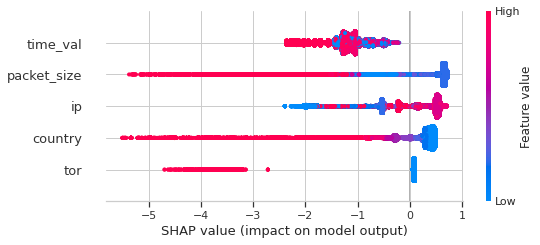

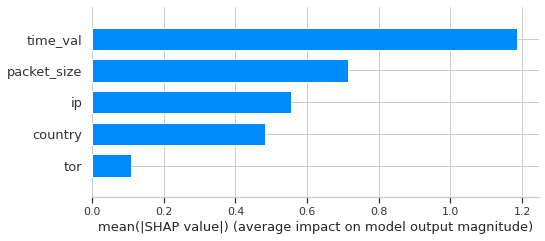

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt

shap.summary_plot(shap_values, X_explain)

shap.summary_plot(shap_values, X_explain, plot_type="bar")

# Show shap on one prediction

In [98]:
idx = 268604
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[idx], x_test.iloc[idx])

# AutoEncoder
Batch Size: 256-1000  
Hyperparameters tuning :  
    a. Optimizer: Adam/RMSProp  
    b. Objective Function: RMSE/MSE  
    c. Layers number: a. as in the paper. (7 layer) b. more hidden layers (9 layers)  
    d. Number of neurons in the layers: a. as in the paper. ([|#Features|, 140, 35, 16, 16, 35, |#Features|]) ,([|#Features|, 256, 36, 16, 8, 16, 36, 256,|#Features|])   
    e. Learning rate: 0.1, 0.01, 0.001

In [26]:
BATCH_SIZE = 256
EPOCHS = 100

pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [27]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [28]:
input_dim = df_train[BEST_FINAL_FEATURES].shape[1] - 1 # minus 'identify'
model_config = {
    'model_name': 'AutoEncoder', 
    'input_dim':input_dim
}
fit_config = {
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE
}

params_grid = {
   'optimizer': ['adam','rmsprop'],
   'loss': [root_mean_squared_error, 'mse', 'mae'],
   'metrics': [["acc"]],
   'architecture': [
       [140, 35, 16, 16],
       [256, 36, 16, 8]
   ],
   'learning_rate': [0.1, 0.01, 0.001]
}

# For output file:
output_dir = Path('/home/ubuntu/nabu/anomaly_detection/outputs')

In [29]:
cv_dict, best_params = cross_validation(params_grid,
                                         df_train[BEST_FINAL_FEATURES + ['ts']], 
                                         df_test[BEST_FINAL_FEATURES + ['ts']],
                                         model_config, 
                                         output_dir,
                                         max_iter=5,
                                         fit_config=fit_config,
                                         pipeline=pipeline)

/home/ubuntu/pyenv/lib/python3.8/site-packages/pandas/core/generic.py:5507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Parameters Random Search iterate number 1
sampled params are: {'optimizer': 'rmsprop', 'loss': 'mae', 'metrics': ['acc'], 'architecture': [256, 36, 16, 8], 'learning_rate': 0.01, 'random_state': 100}
CV iterate number 1
train set size: (755588, 11), val set size: (172173, 11)
transform datasets
loading model
starting training
Epoch 1/100
590/590 [==============================] - 47s 5ms/step - loss: 0.0505 - acc: 0.9864 - val_loss: 0.0107 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 2/100
590/590 [==============================] - 3s 5ms/step - loss: 0.0272 - acc: 0.9966 - val_loss: 0.0140 - val_acc: 0.9999
Epoch 3/100
590/590 [==============================] - 3s 5ms/step - loss: 0.0224 - acc: 0.9983 - val_loss: 0.0162 - val_acc: 0.9999
Epoch 4/100
590/590 [==============================] - 3s 5ms/step - loss: 0.0240 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets

### Best Hyper-Parameters

In [24]:
best_params

{'optimizer': <keras.optimizer_v2.rmsprop.RMSprop at 0x7fe70331a490>,
 'loss': <function keras.losses.mean_squared_error(y_true, y_pred)>,
 'metrics': ['acc'],
 'architecture': [9, 256, 36, 16, 8, 16, 36, 256, 9],
 'learning_rate': 0.1,
 'random_state': 100}

In [42]:
[(cv_dict[cv_i]['mean_results'], cv_dict[cv_i]['params']) for cv_i in cv_dict]

[({'auc': 0.8805000000000001,
   'aucpr': 0.44525,
   'tn': 196661.75,
   'fp': 26562.5,
   'fn': 11.5,
   'tp': 93.25,
   'Normal_precision': 1.0,
   'Normal_recall': 0.87275,
   'Normal_f1-score': 0.93125,
   'Normal_support': 223224.25,
   'Anomalies_precision': 0.0035,
   'Anomalies_recall': 0.8875,
   'Anomalies_f1-score': 0.0072499999999999995,
   'Anomalies_support': 104.75,
   'accuracy': 0.87275,
   'macro avg_precision': 0.502,
   'macro avg_recall': 0.8805000000000001,
   'macro avg_f1-score': 0.46925,
   'macro avg_support': 223329.0,
   'weighted avg_precision': 0.99925,
   'weighted avg_recall': 0.87275,
   'weighted avg_f1-score': 0.931,
   'weighted avg_support': 223329.0},
  {'optimizer': <keras.optimizer_v2.rmsprop.RMSprop at 0x7fe70306feb0>,
   'loss': <function keras.losses.mean_squared_error(y_true, y_pred)>,
   'metrics': ['acc'],
   'architecture': [9, 140, 35, 16, 16, 35, 9],
   'learning_rate': 0.001,
   'random_state': 100}),
 ({'auc': 0.8955,
   'aucpr': 0.46

In [30]:
best_params

{'optimizer': <keras.optimizer_v2.rmsprop.RMSprop at 0x7feb841865b0>,
 'loss': 'mae',
 'metrics': ['acc'],
 'architecture': [256, 36, 16, 8],
 'learning_rate': 0.001,
 'random_state': 100}

In [31]:
[(cv_dict[cv_i]['mean_results'], cv_dict[cv_i]['params']) for cv_i in cv_dict]

[({'auc': 0.8747499999999999,
   'aucpr': 0.46725,
   'tn': 181317.25,
   'fp': 41907.0,
   'fn': 7.25,
   'tp': 97.5,
   'Normal_precision': 1.0,
   'Normal_recall': 0.817,
   'Normal_f1-score': 0.89725,
   'Normal_support': 223224.25,
   'Anomalies_precision': 0.0032500000000000003,
   'Anomalies_recall': 0.93225,
   'Anomalies_f1-score': 0.00625,
   'Anomalies_support': 104.75,
   'accuracy': 0.817,
   'macro avg_precision': 0.5015000000000001,
   'macro avg_recall': 0.8747499999999999,
   'macro avg_f1-score': 0.45199999999999996,
   'macro avg_support': 223329.0,
   'weighted avg_precision': 0.9995,
   'weighted avg_recall': 0.817,
   'weighted avg_f1-score': 0.897,
   'weighted avg_support': 223329.0},
  {'optimizer': <keras.optimizer_v2.rmsprop.RMSprop at 0x7feb44beba00>,
   'loss': 'mae',
   'metrics': ['acc'],
   'architecture': [256, 36, 16, 8],
   'learning_rate': 0.01,
   'random_state': 100}),
 ({'auc': 0.89175,
   'aucpr': 0.46950000000000003,
   'tn': 191296.75,
   'fp':

In [34]:
best_param_res = cv_results_df.iloc[(cv_results_df['auc']).astype(float).argmax()]

In [35]:
best_param_res['params']

{'optimizer': <keras.optimizer_v2.rmsprop.RMSprop at 0x7fe7029eacd0>,
 'loss': 'mse',
 'metrics': ['acc'],
 'architecture': [9, 256, 36, 16, 8, 16, 36, 256, 9],
 'learning_rate': 0.01,
 'random_state': 100}

In [36]:
best_param_res

cv_i                                                                      2
params                    {'optimizer': <keras.optimizer_v2.rmsprop.RMSp...
auc                                                                  0.9005
aucpr                                                                 0.469
tn                                                                 195988.5
fp                                                                 27235.75
fn                                                                      6.5
tp                                                                    98.25
Normal_precision                                                        1.0
Normal_recall                                                       0.86525
Normal_f1-score                                                     0.92675
Normal_support                                                    223224.25
Anomalies_precision                                                 0.00375
Anomalies_re

### Full Train

In [10]:
BATCH_SIZE = 256
EPOCHS = 100

pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

input_dim = df_train[BEST_FINAL_FEATURES].shape[1] - 1 # minus 'identify'
model_config = {
    'model_name': 'AutoEncoder', 
    'input_dim': input_dim,
    'params': {
        'optimizer': 'rmsprop',
        'loss': 'mae',
        'metrics': ['acc'],
        'architecture': [256, 36, 16, 8],
        'learning_rate': 0.001
    }
}
fit_config = {
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE
}

In [14]:
ae_result, model = train_dl(df_train[BEST_FINAL_FEATURES], df_test[BEST_FINAL_FEATURES], model_config, comment='full train', fit_config=fit_config, pipeline=pipeline, output_model=True)
ae_result

transform datasets
loading model
starting training


2021-10-02 20:49:58.345210: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-02 20:49:58.346138: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-02 20:49:58.348082: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-16-27): /proc/driver/nvidia/version does not exist
2021-10-02 20:49:58.359475: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-02 20:49:58.834825: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLI

Epoch 1/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0150 - acc: 0.9988 - val_loss: 0.0105 - val_acc: 0.9999


2021-10-02 20:50:05.619587: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 2/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0070 - acc: 0.9997 - val_loss: 0.0071 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 3/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0056 - acc: 0.9997 - val_loss: 0.0045 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 4/100
1067/1067 [==============================] - 5s 5ms/step - loss: 0.0051 - acc: 0.9997 - val_loss: 0.0068 - val_acc: 0.9999
Epoch 5/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0047 - acc: 0.9997 - val_loss: 0.0045 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 6/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0042 - acc: 0.9997 - val_loss: 0.0044 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencode

{'auc': 0.935,
 'aucpr': 0.481,
 'tn': 257707,
 'fp': 25144,
 'fn': 3,
 'tp': 71,
 'Normal_precision': 1.0,
 'Normal_recall': 0.911,
 'Normal_f1-score': 0.953,
 'Normal_support': 282851,
 'Anomalies_precision': 0.003,
 'Anomalies_recall': 0.959,
 'Anomalies_f1-score': 0.006,
 'Anomalies_support': 74,
 'accuracy': 0.911,
 'macro avg_precision': 0.501,
 'macro avg_recall': 0.935,
 'macro avg_f1-score': 0.48,
 'macro avg_support': 282925,
 'weighted avg_precision': 1.0,
 'weighted avg_recall': 0.911,
 'weighted avg_f1-score': 0.953,
 'weighted avg_support': 282925,
 'model_name': 'AutoEncoder',
 'train_duration': datetime.timedelta(seconds=168, microseconds=992485),
 'time': '2021-10-02 20:52:52.536498',
 'comment': 'full train'}

In [15]:
model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  90        
_________________________________________________________________
dense_1 (Dense)              multiple                  360       
_________________________________________________________________
dense_2 (Dense)              multiple                  592       
_________________________________________________________________
dense_3 (Dense)              multiple                  136       
_________________________________________________________________
dense_4 (Dense)              multiple                  144       
_________________________________________________________________
dense_5 (Dense)              multiple                  612       
_________________________________________________________________
dense_6 (Dense)              multiple                  

In [20]:
X_train = df_train[df_train.identify==0][BEST_FINAL_FEATURES]
y_train = X_train.pop('identify')
pipeline.fit(X_train)

X_test = df_train[BEST_FINAL_FEATURES]
y_test = X_test.pop('identify')
X_test_transformed = pipeline.transform(X_test)
reconstructions_test = model.get_outliers(X_test_transformed)

Pipeline(steps=[('normalizer', Normalizer()), ('scaler', MinMaxScaler())])

In [22]:
encoder = tf.keras.models.Sequential(model.encoder)
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 90        
_________________________________________________________________
dense_1 (Dense)              (None, 36)                360       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                592       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
Total params: 1,178
Trainable params: 1,178
Non-trainable params: 0
_________________________________________________________________


In [25]:
RATIO_TO_MALICIOUS = 15


mal = X_test_transformed[y_test.astype(int).values ==1]
clean = X_test_transformed[y_test.astype(int).values ==0][:len(mal) * RATIO_TO_MALICIOUS, ]

# combining arrays & building labels
features = np.append(mal, clean, axis=0)
labels = np.append(np.ones(len(mal)),
                   np.zeros(len(clean)))

# getting latent space representation
latent_representation = encoder.predict(features)

In [32]:
y_test.shape

(1365979,)

In [31]:
latent_representation.shape

(16016, 8)

In [46]:
%matplotlib inline
from sklearn.manifold import TSNE
import time

df_subset = pd.DataFrame()
df_subset['is_anomaly'] = labels
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(latent_representation)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 16016 samples in 0.017s...
[t-SNE] Computed neighbors for 16016 samples in 0.392s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16016
[t-SNE] Computed conditional probabilities for sample 2000 / 16016
[t-SNE] Computed conditional probabilities for sample 3000 / 16016
[t-SNE] Computed conditional probabilities for sample 4000 / 16016
[t-SNE] Computed conditional probabilities for sample 5000 / 16016
[t-SNE] Computed conditional probabilities for sample 6000 / 16016
[t-SNE] Computed conditional probabilities for sample 7000 / 16016
[t-SNE] Computed conditional probabilities for sample 8000 / 16016
[t-SNE] Computed conditional probabilities for sample 9000 / 16016
[t-SNE] Computed conditional probabilities for sample 10000 / 16016
[t-SNE] Computed conditional probabilities for sample 11000 / 16016
[t-SNE] Computed conditional probabilities for sample 12000 / 16016
[t-SNE] Computed conditional probabilities for sa

<Figure size 1152x720 with 0 Axes>

[Text(0.5, 0, ''),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Decoder Dense Representations')]

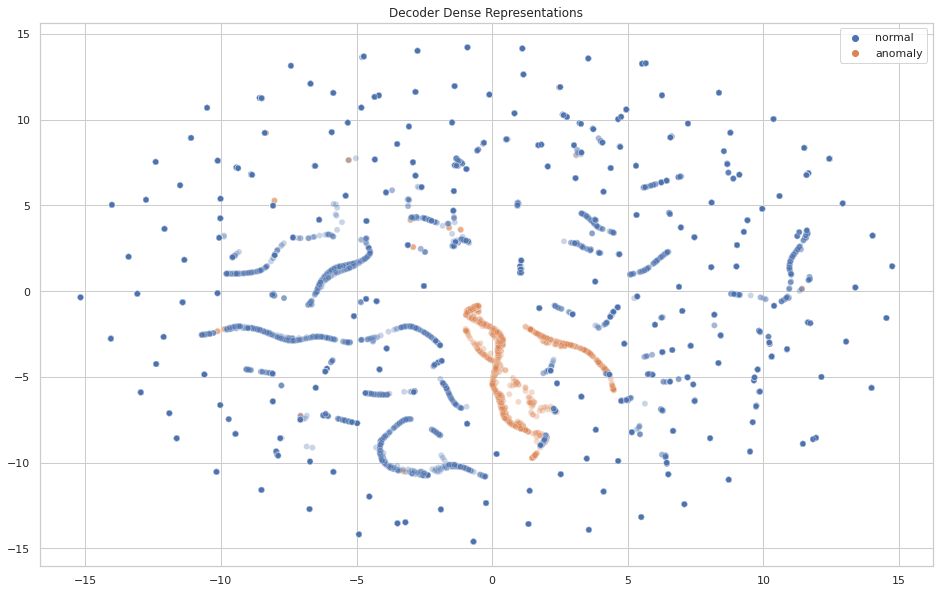

In [59]:
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="is_anomaly",
#     palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend='full',
    alpha=0.3
)
ax.set(xlabel=None, ylabel=None, title='Decoder Dense Representations')
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['normal', 'anomaly'] title='')

In [57]:
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['normal', 'anomaly'])

In [10]:
ae_result = train(df_train[BEST_FINAL_FEATURES], df_test[BEST_FINAL_FEATURES], model_config, comment='full train', fit_config=fit_config, pipeline=pipeline)
ae_result

transform datasets
loading model
starting training
Epoch 1/100


2021-10-02 08:58:22.071339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-02 08:58:22.071372: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-02 08:58:22.071392: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-16-27): /proc/driver/nvidia/version does not exist
2021-10-02 08:58:22.071593: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-02 08:58:22.234564: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLI

1067/1067 [==============================] - 6s 5ms/step - loss: 0.0150 - acc: 0.9988 - val_loss: 0.0105 - val_acc: 0.9999


2021-10-02 08:58:28.821058: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 2/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0070 - acc: 0.9997 - val_loss: 0.0071 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 3/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0056 - acc: 0.9997 - val_loss: 0.0045 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 4/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0051 - acc: 0.9997 - val_loss: 0.0068 - val_acc: 0.9999
Epoch 5/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0047 - acc: 0.9997 - val_loss: 0.0045 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 6/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0042 - acc: 0.9997 - val_loss: 0.0044 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencode

{'auc': 0.856,
 'aucpr': 0.5,
 'tn': 201108,
 'fp': 81743,
 'fn': 0,
 'tp': 74,
 'Normal_precision': 1.0,
 'Normal_recall': 0.711,
 'Normal_f1-score': 0.831,
 'Normal_support': 282851,
 'Anomalies_precision': 0.001,
 'Anomalies_recall': 1.0,
 'Anomalies_f1-score': 0.002,
 'Anomalies_support': 74,
 'accuracy': 0.711,
 'macro avg_precision': 0.5,
 'macro avg_recall': 0.856,
 'macro avg_f1-score': 0.416,
 'macro avg_support': 282925,
 'weighted avg_precision': 1.0,
 'weighted avg_recall': 0.711,
 'weighted avg_f1-score': 0.831,
 'weighted avg_support': 282925,
 'model_name': 'AutoEncoder',
 'train_duration': datetime.timedelta(seconds=169, microseconds=135146),
 'time': '2021-10-02 09:01:16.399831',
 'comment': 'full train'}

In [11]:
model_config['input_dim'] = df_train[FEATURES_WITHOUT_AGGS].shape[1] - 1 # minus 'identify'
ae_result_without_agg = train(df_train[FEATURES_WITHOUT_AGGS], df_test[FEATURES_WITHOUT_AGGS], model_config, comment='full train', fit_config=fit_config, pipeline=pipeline)

transform datasets
loading model
starting training
Epoch 1/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0216 - acc: 0.9990 - val_loss: 0.0134 - val_acc: 0.9995
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 2/100
1067/1067 [==============================] - 5s 5ms/step - loss: 0.0093 - acc: 1.0000 - val_loss: 0.0116 - val_acc: 0.9995
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 3/100
1067/1067 [==============================] - 5s 5ms/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9995
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 4/100
1067/1067 [==============================] - 5s 5ms/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 0.9995
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 5/100
1067/1067 [==============================] - 5s 5ms/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0

In [13]:
ae_result_without_agg

{'auc': 0.848,
 'aucpr': 0.399,
 'tn': 254104,
 'fp': 28747,
 'fn': 15,
 'tp': 59,
 'Normal_precision': 1.0,
 'Normal_recall': 0.898,
 'Normal_f1-score': 0.946,
 'Normal_support': 282851,
 'Anomalies_precision': 0.002,
 'Anomalies_recall': 0.797,
 'Anomalies_f1-score': 0.004,
 'Anomalies_support': 74,
 'accuracy': 0.898,
 'macro avg_precision': 0.501,
 'macro avg_recall': 0.848,
 'macro avg_f1-score': 0.475,
 'macro avg_support': 282925,
 'weighted avg_precision': 1.0,
 'weighted avg_recall': 0.898,
 'weighted avg_f1-score': 0.946,
 'weighted avg_support': 282925,
 'model_name': 'AutoEncoder',
 'train_duration': datetime.timedelta(seconds=186, microseconds=479570),
 'time': '2021-10-02 09:05:12.758663',
 'comment': 'full train'}

In [13]:
BATCH_SIZE = 256
EPOCHS = 100

pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

input_dim = df_train[BEST_FINAL_FEATURES].shape[1] - 1 # minus 'identify'
model_config = {
    'model_name': 'AutoEncoder', 
    'input_dim': input_dim,
    'params': {
        'optimizer': 'rmsprop',
        'loss': 'mae',
        'metrics': ['acc'],
        'architecture': [256, 36, 16, 8],
        'learning_rate': 0.001
    }
}
fit_config = {
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE
}

In [10]:
# thresholds 4.75
ae_result = train(df_train[BEST_FINAL_FEATURES], df_test[BEST_FINAL_FEATURES], model_config, comment='full train', fit_config=fit_config, pipeline=pipeline)
ae_result

transform datasets
loading model
starting training
Epoch 1/100


2021-10-02 09:49:47.308511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-02 09:49:47.308544: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-02 09:49:47.308561: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-16-27): /proc/driver/nvidia/version does not exist
2021-10-02 09:49:47.308766: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-02 09:49:47.470708: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLI

1067/1067 [==============================] - 6s 5ms/step - loss: 0.0150 - acc: 0.9988 - val_loss: 0.0105 - val_acc: 0.9999


2021-10-02 09:49:54.074207: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 2/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0070 - acc: 0.9997 - val_loss: 0.0071 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 3/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0056 - acc: 0.9997 - val_loss: 0.0045 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 4/100
1067/1067 [==============================] - 5s 5ms/step - loss: 0.0051 - acc: 0.9997 - val_loss: 0.0068 - val_acc: 0.9999
Epoch 5/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0047 - acc: 0.9997 - val_loss: 0.0045 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 6/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0042 - acc: 0.9997 - val_loss: 0.0044 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencode

{'auc': 0.93,
 'aucpr': 0.481,
 'tn': 254793,
 'fp': 28058,
 'fn': 3,
 'tp': 71,
 'Normal_precision': 1.0,
 'Normal_recall': 0.901,
 'Normal_f1-score': 0.948,
 'Normal_support': 282851,
 'Anomalies_precision': 0.003,
 'Anomalies_recall': 0.959,
 'Anomalies_f1-score': 0.005,
 'Anomalies_support': 74,
 'accuracy': 0.901,
 'macro avg_precision': 0.501,
 'macro avg_recall': 0.93,
 'macro avg_f1-score': 0.476,
 'macro avg_support': 282925,
 'weighted avg_precision': 1.0,
 'weighted avg_recall': 0.901,
 'weighted avg_f1-score': 0.948,
 'weighted avg_support': 282925,
 'model_name': 'AutoEncoder',
 'train_duration': datetime.timedelta(seconds=168, microseconds=848750),
 'time': '2021-10-02 09:52:41.395285',
 'comment': 'full train'}

In [10]:
# thresholds 5
ae_result = train(df_train[BEST_FINAL_FEATURES], df_test[BEST_FINAL_FEATURES], model_config, comment='full train', fit_config=fit_config, pipeline=pipeline)
ae_result

transform datasets
loading model
starting training
Epoch 1/100


2021-10-02 09:35:57.895265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-02 09:35:57.895301: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-02 09:35:57.895318: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-16-27): /proc/driver/nvidia/version does not exist
2021-10-02 09:35:57.895516: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-02 09:35:58.058726: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLI

1067/1067 [==============================] - 6s 5ms/step - loss: 0.0150 - acc: 0.9988 - val_loss: 0.0105 - val_acc: 0.9999


2021-10-02 09:36:04.687088: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 2/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0070 - acc: 0.9997 - val_loss: 0.0071 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 3/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0056 - acc: 0.9997 - val_loss: 0.0045 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 4/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0051 - acc: 0.9997 - val_loss: 0.0068 - val_acc: 0.9999
Epoch 5/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0047 - acc: 0.9997 - val_loss: 0.0045 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 6/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0042 - acc: 0.9997 - val_loss: 0.0044 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencode

{'auc': 0.935,
 'aucpr': 0.481,
 'tn': 257707,
 'fp': 25144,
 'fn': 3,
 'tp': 71,
 'Normal_precision': 1.0,
 'Normal_recall': 0.911,
 'Normal_f1-score': 0.953,
 'Normal_support': 282851,
 'Anomalies_precision': 0.003,
 'Anomalies_recall': 0.959,
 'Anomalies_f1-score': 0.006,
 'Anomalies_support': 74,
 'accuracy': 0.911,
 'macro avg_precision': 0.501,
 'macro avg_recall': 0.935,
 'macro avg_f1-score': 0.48,
 'macro avg_support': 282925,
 'weighted avg_precision': 1.0,
 'weighted avg_recall': 0.911,
 'weighted avg_f1-score': 0.953,
 'weighted avg_support': 282925,
 'model_name': 'AutoEncoder',
 'train_duration': datetime.timedelta(seconds=171, microseconds=6287),
 'time': '2021-10-02 09:38:54.057863',
 'comment': 'full train'}